In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI, FMRI_SURFACE_LEVEL_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, IDS_IMAGES_TEST, IDS_IMAGES_IMAGERY, IMAGERY_SCENES
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, \
ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, Normalize, IMAGE, CAPTION, get_distance_matrix, \
ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, calc_all_pairwise_accuracy_scores, get_nn_latent_data

from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, PALETTE_BLACK_ONLY, METRICS_IMAGERY

In [19]:
MODELS = ["clip", "imagebind", "flava", "blip2"]
all_data = load_results_data(MODELS, metrics=METRICS_IMAGERY)

100%|██████████| 1271/1271 [00:14<00:00, 86.53it/s] 


In [20]:
# MODELS = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
#                "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
#                "visualbert", "lxmert", "bridgetower-large", "vilt", "clip", "imagebind", "flava", "blip2"]
data_whole_brain = all_data.copy()

data_whole_brain = data_whole_brain[pd.isna(data_whole_brain["mask"])]
data_whole_brain = data_whole_brain[data_whole_brain.surface == False]

data_whole_brain
# for model in MODEL_ORDER:
#     print(model, end=" ")
# all_data = all_data[all_data.subject.isin(['sub-01', 'sub-02', 'sub-03', 'sub-04'])]
# all_data_glow_comparisons

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
0,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,predictions,"[[0.0056858445, -0.0073180436, 0.0019684248, -...",False,NaN,blip2_avg
1,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,latents,"[[-0.032183096, 0.9773568, -1.0357457, -0.8727...",False,NaN,blip2_avg
2,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,stimulus_ids,"[3862, 6450, 16764, 25902, 38938, 43966, 47566...",False,NaN,blip2_avg
3,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,stimulus_types,"[caption, caption, caption, caption, caption, ...",False,NaN,blip2_avg
4,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.889441,False,NaN,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,predictions,"[[0.03618381, -0.013561214, 0.016098907, 0.047...",False,NaN,imagebind_matched
3405,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,latents,"[[152.46083, -225.88083, 43.110928, 6.8893604,...",False,NaN,imagebind_matched
3406,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,stimulus_ids,"[3862, 6450, 16764, 25902, 38938, 43966, 47566...",False,NaN,imagebind_matched
3407,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,stimulus_types,"[caption, caption, caption, caption, caption, ...",False,NaN,imagebind_matched


In [21]:
def get_data_default_feats(data):
    data_default_feats = data.copy()
    for model in data.model.unique():
        default_feats = get_default_features(model)
        default_vision_feats = get_default_vision_features(model)
        default_lang_feats = get_default_lang_features(model)
        data_default_feats = data_default_feats[((data_default_feats.model == model) & (data_default_feats.features == default_feats) & (data_default_feats.vision_features == default_vision_feats) & (data_default_feats.lang_features == default_lang_feats)) | (data_default_feats.model != model)]
        
    return data_default_feats
    
data_default_feats = get_data_default_feats(data_whole_brain)

Selected default features for blip2: avg
Selected default vision features for blip2: vision_features_mean
Selected default lang features for blip2: lang_features_mean
Selected default features for clip: avg
Selected default vision features for clip: vision_features_cls
Selected default lang features for clip: lang_features_cls
Selected default features for flava: avg
Selected default vision features for flava: vision_features_mean
Selected default lang features for flava: lang_features_mean
Selected default features for imagebind: avg
Selected default vision features for imagebind: vision_features_cls
Selected default lang features for imagebind: lang_features_cls


### Model performance ranking

In [22]:
dp = data_default_feats.copy()
dp = dp[dp.training_mode == 'modality-agnostic']

dp = dp[dp.metric == ACC_IMAGERY_WHOLE_TEST]
for model in dp.model.unique():
    if len(dp[dp.model == model]) != len(SUBJECTS):
        print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
scores = dp.groupby("model").value.mean().sort_values()

print(scores)

model
clip         0.734742
blip2        0.769953
flava         0.77543
imagebind    0.808294
Name: value, dtype: object


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()])


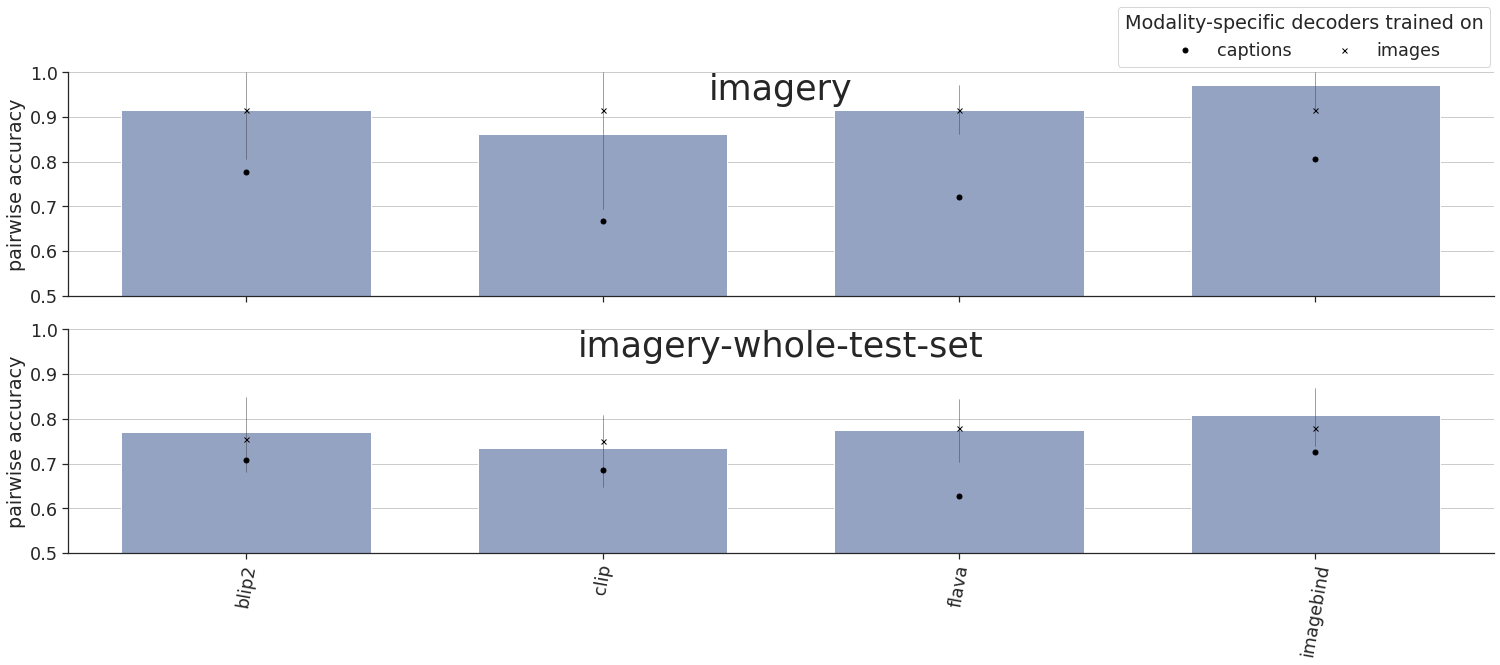

In [25]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = data_to_plot.model_feat.unique()
# print(model_feat_order)

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", plot_legend=False, verify_num_datapoints=False)

# plt.savefig(os.path.join(RESULTS_DIR, f"imagery_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# Pairwise acc scores

In [26]:
MODEL = "imagebind"
df_model = data_default_feats[data_default_feats.model == MODEL]

train_latents = dict()
train_stim_ids = dict()
for subject in SUBJECTS:
    assert len(df_model.vision_features.unique()) == 1
    features = df_model.features.values[0]
    # print(features)
    vision_features = df_model.vision_features.values[0]
    # print(vision_features)
    lang_features = df_model.lang_features.values[0]
    # print(lang_features)
    all_stim_ids = pickle.load(open(STIMULI_IDS_PATH, "rb"))
    train_stim_ids[subject] = np.array(list(set(all_stim_ids) - set(IDS_IMAGES_IMAGERY) - set(IDS_IMAGES_TEST)))
    train_stim_types = ["image"] * len(train_stim_ids[subject])
    train_latents[subject], _ = get_nn_latent_data(
                                        MODEL, features,
                                        vision_features,
                                        lang_features,
                                        train_stim_ids[subject],
                                        train_stim_types,
                                        subject,
                                        "train",
                                        recompute_std_mean=False
                                    )

In [27]:
all_scores = []

df = data_default_feats.copy()
df_model = df[df.model == MODEL]

for subject in SUBJECTS:
    df_subj = df_model[(df_model.training_mode == 'modality-agnostic') & (df_model.subject == subject)]
    test_predictions = df_subj[df_subj.metric == "predictions"].value.item()
    test_latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

    imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
    imagery_latents = df_subj[df_subj.metric == "imagery_latents"].value.item()

    test_latents_image = test_latents[stimulus_types == IMAGE]
    test_latents_caption = test_latents[stimulus_types == CAPTION]

    candidate_set_latents = np.concatenate((imagery_latents, test_latents))
    # candidate_set_latents = np.concatenate((imagery_latents, train_latents[subject]))

    res = pairwise_accuracy(candidate_set_latents, imagery_predictions)
    
    # print(res)
    all_scores.append(res)
        # all_scores.append(res[ACC_IMAGES])
        # break
print(np.mean(all_scores))



0.8082942097026603


# Imagery decoding with mask

In [9]:
model_order = ["blip2"]
resolution = "fsaverage7"
training_mode = "images"


data_models = all_data[all_data.model.isin(model_order)].copy()
data_models = data_models[data_models.training_mode == training_mode]

data_models = data_models[~pd.isna(data_models["mask"])]

data_models["mask"] = data_models["mask"].apply(lambda x: os.path.basename(x).replace("p_values_", "").replace(".p", ""))
print(data_models["mask"].unique())

data_models = data_models[data_models.resolution == resolution]
data_models = data_models[data_models.surface == True]

data_cls_feats = data_models.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]

data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]
# data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

data_matched_feats

['thresh_0.01_left_cluster_0' 'thresh_0.01_left_cluster_1'
 'thresh_0.01_left_cluster_2' 'thresh_0.01_left_cluster_9'
 'thresh_0.01_right_cluster_0' 'thresh_0.01_right_cluster_1' 'thresh_0.01'
 'metric_3_h_2.0_e_1.0_smoothed_0']


,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
2340,10000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,images,thresh_0.01_left_cluster_0,2063,predictions,"[[-0.008961635, 0.005859438, 0.02255739, 0.007...",True,fsaverage7,blip2_matched
2341,10000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,images,thresh_0.01_left_cluster_0,2063,latents,"[[-1.653454, 1.3070148, -1.9536605, 0.1089143,...",True,fsaverage7,blip2_matched
2342,10000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,images,thresh_0.01_left_cluster_0,2063,stimulus_ids,"[3862, 6450, 16764, 25902, 38938, 43966, 47566...",True,fsaverage7,blip2_matched
2343,10000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,images,thresh_0.01_left_cluster_0,2063,stimulus_types,"[caption, caption, caption, caption, caption, ...",True,fsaverage7,blip2_matched
2344,10000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,images,thresh_0.01_left_cluster_0,2063,pairwise_acc_imagery,1.0,True,fsaverage7,blip2_matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,10000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,thresh_0.01,7034,pairwise_acc_imagery,0.833333,True,fsaverage7,blip2_matched
3323,10000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,thresh_0.01,7034,pairwise_acc_imagery_whole_test_set,0.852113,True,fsaverage7,blip2_matched
3324,10000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,thresh_0.01,7034,imagery_predictions,"[[-0.014572752, 0.009573183, 0.004857061, -0.0...",True,fsaverage7,blip2_matched
3325,10000.0,blip2,sub-07,matched,vision_features_cls,lang_features_cls,images,thresh_0.01,7034,imagery_latents,"[[0.37338445, 0.52278244, 1.0123829, -0.109391...",True,fsaverage7,blip2_matched


In [10]:
print(data_matched_feats[(data_matched_feats.metric == ACC_IMAGERY)].groupby(["mask", "metric"])['value'].mean())
print(data_matched_feats[(data_matched_feats.metric == ACC_IMAGERY)].groupby(["mask", "metric"])['value'].count())


mask                         metric              
thresh_0.01                  pairwise_acc_imagery        0.75
thresh_0.01_left_cluster_0   pairwise_acc_imagery    0.805556
thresh_0.01_left_cluster_1   pairwise_acc_imagery    0.694444
thresh_0.01_left_cluster_2   pairwise_acc_imagery    0.611111
thresh_0.01_left_cluster_9   pairwise_acc_imagery         0.5
thresh_0.01_right_cluster_0  pairwise_acc_imagery    0.611111
thresh_0.01_right_cluster_1  pairwise_acc_imagery    0.388889
Name: value, dtype: object
mask                         metric              
thresh_0.01                  pairwise_acc_imagery    6
thresh_0.01_left_cluster_0   pairwise_acc_imagery    6
thresh_0.01_left_cluster_1   pairwise_acc_imagery    6
thresh_0.01_left_cluster_2   pairwise_acc_imagery    6
thresh_0.01_left_cluster_9   pairwise_acc_imagery    6
thresh_0.01_right_cluster_0  pairwise_acc_imagery    6
thresh_0.01_right_cluster_1  pairwise_acc_imagery    6
Name: value, dtype: int64


In [28]:

FEAT_ORDER = ["vision", "lang", "vision+lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')
PALETTE_BLACK_ONLY = [(0, 0, 0)] * 10


def create_result_graph_cluster_comparisons(data, x_variable="model_feat", order=None, metrics=["pairwise_acc_captions", "pairwise_acc_images"],
                        hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Legend", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None,
                        row_variable="metric", row_order=None, col_variable=None, legend_bbox=(0.06, 0.97),
                        legend_2_bbox=(0.99, 0.97), height=4.5, row_title_height=0.85, aspect=4,
                        verify_num_datapoints=True):

    for x_variable_value in order:
        length = len(data[(data[x_variable] == x_variable_value) & (data.metric == metrics[0])])
        expected_num_datapoints = len(SUBJECTS)
        if hue_variable != "features":
            expected_num_datapoints *= len(data[hue_variable].unique())
        if (length > 0) and (length != expected_num_datapoints):
            message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) ({x_variable}: {x_variable_value} {mode}"
            if verify_num_datapoints:
                raise RuntimeError(message)
            else:
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data, order=order, metrics=metrics,
                                                       x_variable=x_variable, legend_title=legend_title,
                                                       legend_bbox=legend_bbox, height=height, aspect=aspect,
                                                       hue_variable=hue_variable, row_variable=row_variable,
                                                       row_order=row_order, col_variable=col_variable,
                                                       hue_order=hue_order, palette=palette, ylim=ylim,
                                                       noise_ceilings=noise_ceilings, shorten_label_texts=False, plot_legend=False)

    for m, metric in enumerate(metrics):
        catplot_g.axes[m, 0].set_title(metrics[m].replace("pairwise_acc_", "").replace("_", "-"), fontsize=35,
                                       y=row_title_height)
        catplot_g.axes[m, 0].set_ylabel('pairwise accuracy')

    plt.subplots_adjust(hspace=0.15)
    return catplot_g, lgd


['thresh_0.01_left_cluster_0' 'thresh_0.01_left_cluster_1'
 'thresh_0.01_left_cluster_2' 'thresh_0.01_left_cluster_9'
 'thresh_0.01_right_cluster_0' 'thresh_0.01_right_cluster_1' 'thresh_0.01']


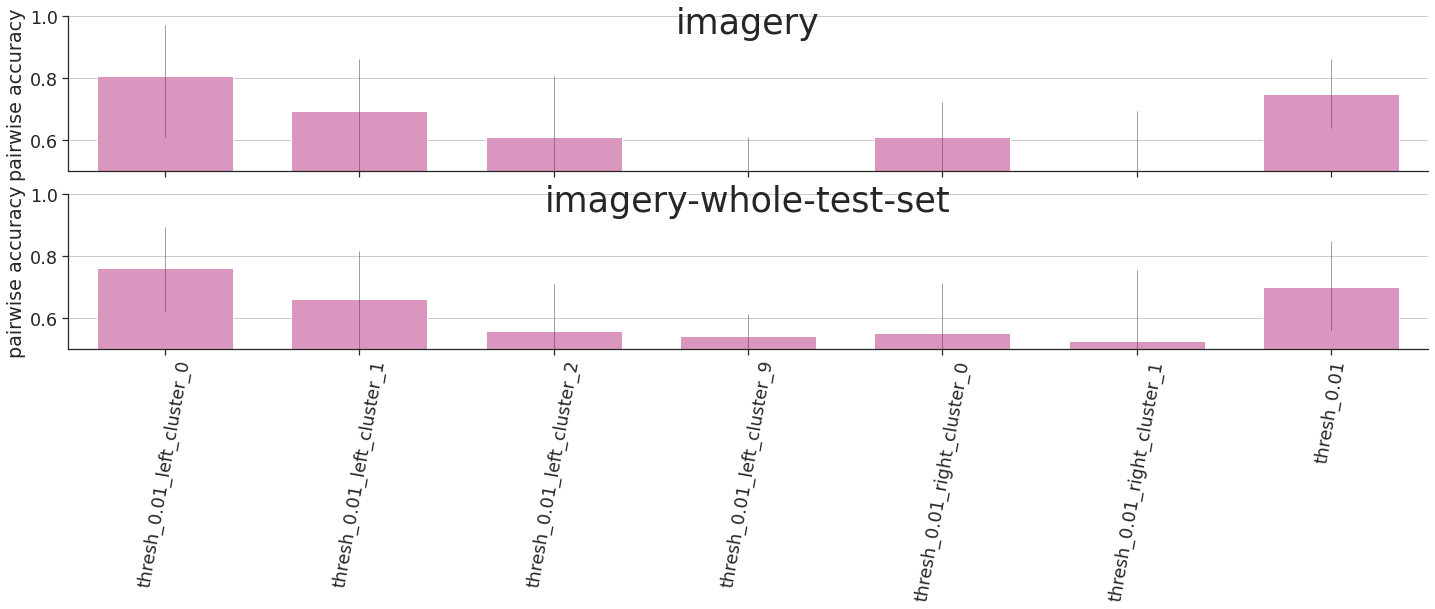

In [29]:
metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
order = data_matched_feats["mask"].unique()

print(order)
figure, lgd = create_result_graph_cluster_comparisons(data_matched_feats, x_variable="mask", order=order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)





# Nearest Neighbors of imagined pictures

In [14]:
from utils import COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH
from feature_extraction.feat_extraction_utils import CoCoDataset
from PIL import Image

coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH, 'image')

def display_stimuli(coco_ids):
    imgs = [coco_ds.get_img_by_coco_id(img_id) for img_id in coco_ids]
    min_height = np.min([np.array(im).shape[0] for im in imgs])
    stacked = np.hstack([np.array(im)[:min_height,:,:] for im in imgs])
    img = Image.fromarray(stacked)
    display(img)


In [15]:
# training_mode = 'modality-agnostic'
# df = data_default_feats.copy()
# df_model = df[df.model == MODEL]
# # for subject in SUBJECTS:
# #     print(subject)
# df_mode = df_model[(df_model.training_mode == training_mode)]
# all_subj_imagery_preds = df_mode[df_mode.metric == "imagery_predictions"].value.to_numpy()
# all_subj_imagery_preds = np.concatenate(all_subj_imagery_preds)
# all_subj_imagery_preds.shape

In [ ]:
%precision 3

MODEL = "blip2"
training_mode = 'modality-agnostic'
# training_mode = 'images'

df = data_default_feats.copy()
df_model = df[df.model == MODEL]
all_ranks = []
for subject in SUBJECTS:
    print(subject)
    df_subj = df_model[(df_model.training_mode == training_mode) & (df_model.subject == subject)]
    test_predictions = df_subj[df_subj.metric == "predictions"].value.item()
    test_latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()

    imagery_predictions = df_subj[df_subj.metric == "imagery_predictions"].value.item()
    imagery_latents = df_subj[df_subj.metric == "imagery_latents"].value.item()

    test_latents_image = test_latents[stimulus_types == IMAGE]
    test_latents_caption = test_latents[stimulus_types == CAPTION]

    candidate_set_latents = np.concatenate((imagery_latents, test_latents))
    # candidate_set_latents = np.concatenate((imagery_latents, train_latents[subject]))
    imagery_stimulus_ids = np.array([i[1] for i in IMAGERY_SCENES[subject]])
    imagery_stimulus_captions = np.array([i[0] for i in IMAGERY_SCENES[subject]])

    candidate_set_latents_ids = np.concatenate((imagery_stimulus_ids, train_stim_ids[subject]))
   
    preds_normalize = Normalize(imagery_predictions.mean(axis=0), imagery_predictions.std(axis=0))
    imagery_predictions = preds_normalize(imagery_predictions)

    dist_mat = get_distance_matrix(imagery_predictions, candidate_set_latents)
    
    for imagery_stimulus_id, imagery_stimulus_caption, nneighbors_row in zip(imagery_stimulus_ids, imagery_stimulus_captions, dist_mat):
        print(f"imagery stimulus: {imagery_stimulus_caption}")
        # display(coco_ds.get_img_by_coco_id(imagery_stimulus_id))
        target_location = np.argwhere(candidate_set_latents_ids == imagery_stimulus_id)[0][0]
        nneighbors_ids = candidate_set_latents_ids[np.argsort(nneighbors_row)]
        rank = np.argwhere(nneighbors_ids == imagery_stimulus_id)[0][0]
        all_ranks.append(rank)
        display(f"distance to target: {nneighbors_row[target_location]:.3f} | rank: {rank} of {len(nneighbors_row)}")
        display(f"nearest neighbors distances: {np.sort(nneighbors_row)[:10]}")
        display_stimuli(nneighbors_ids[:10])
    print()

print(all_ranks)
print(np.mean(all_ranks))
print(np.mean(all_ranks)/len(nneighbors_row))

# 